In [2]:
import os
from nuscenes import NuScenes
import numpy as np
import torch
import torch.nn as nn

In [3]:
# Path to your nuScenes mini dataset
data_path = 'v1.0-mini'  # Replace with the actual path to the dataset

# Load the dataset
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 6.123 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [6]:
import os
from nuscenes import NuScenes
import numpy as np

# Path to your nuScenes mini dataset
data_path = 'v1.0-mini'  # Replace with the actual path to the dataset

# Load the dataset
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)

# Function to extract agents from a sample
def extract_agents_from_sample(sample_token):
    sample = nusc.get('sample', sample_token)
    # Get annotations (agents) in this sample
    annotations = []
    for ann_token in sample['anns']:
        ann = nusc.get('sample_annotation', ann_token)
        annotations.append(ann)
    return annotations

# Function to calculate the Euclidean distance between two points (agents)
def calculate_distance(agent1, agent2):
    pos1 = np.array(agent1['translation'])  # Position of agent 1
    pos2 = np.array(agent2['translation'])  # Position of agent 2
    return np.linalg.norm(pos1 - pos2)  # Euclidean distance

# Function to calculate influence scores based on distance
def calculate_influence_score(agent1, agent2):
    distance = calculate_distance(agent1, agent2)
    if distance == 0:
        return 1  # Maximum influence if agents are at the same position
    return 1 / distance  # Inverse proportional influence score

# Extract the first scene and sample data
scene = nusc.scene[0]  # Get the first scene (for simplicity)
first_sample_token = scene['first_sample_token']
annotations = extract_agents_from_sample(first_sample_token)

# Display the agents (we'll use their positions and types)
for ann in annotations:
    category_name = ann['category_name']  # Get the category name directly
    print(f"Agent Type: {category_name} | Position: {ann['translation']}")

# Example: Calculate influence scores between the first two agents
if len(annotations) >= 2:
    agent1 = annotations[0]  # First agent
    agent2 = annotations[1]  # Second agent

    influence_score = calculate_influence_score(agent1, agent2)
    print(f'Influence Score between Agent 1 and Agent 2: {influence_score}')

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.758 seconds.
Reverse indexing ...
Done reverse indexing in 0.0 seconds.
Agent Type: human.pedestrian.adult | Position: [373.256, 1130.419, 0.8]
Agent Type: human.pedestrian.adult | Position: [378.888, 1153.348, 0.865]
Agent Type: vehicle.car | Position: [353.794, 1132.355, 0.602]
Agent Type: human.pedestrian.adult | Position: [376.13, 1158.507, 0.938]
Agent Type: movable_object.trafficcone | Position: [410.066, 1196.767, 0.656]
Agent Type: vehicle.bicycle | Position: [372.664, 1129.247, 0.672]
Agent Type: human.pedestrian.adult | Position: [378.657, 1151.026, 0.833]
Agent Type: vehicle.car | Position: [409.132, 1201.516, 1.01]
Agent Type: human.pedestrian.adult | Position: [396.335, 1122.142, 0.513]
Agent Type: movable_object.barrier | Pos

In [13]:
# Define dataset class for trajectory data
class TrajectoryDataset(Dataset):
    def __init__(self, data, use_influence_score=False):
        self.data = data
        self.use_influence_score = use_influence_score

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        trajectory = sample['trajectory']
        if self.use_influence_score:
            influence_score = sample['influence_score']
            return torch.tensor(trajectory, dtype=torch.float32), torch.tensor([influence_score], dtype=torch.float32)
        return torch.tensor(trajectory, dtype=torch.float32), torch.tensor([0], dtype=torch.float32)

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, use_influence_score=False):
        super(TrajectoryLSTM, self).__init__()
        self.use_influence_score = use_influence_score
        input_features = input_dim + 1 if use_influence_score else input_dim
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, influence_score=None):
        if self.use_influence_score and influence_score is not None:
            # Ensure influence_score has the correct shape for concatenation
            influence_score = influence_score.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat along the sequence dimension
            x = torch.cat((x, influence_score), dim=2)  # Add influence score as an additional feature
            
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Predict only the final timestep

# Training function
def train(model, loader, optimizer, criterion, use_influence_score):
    model.train()
    total_loss = 0
    for trajectory, influence_score in loader:
        optimizer.zero_grad()
        if use_influence_score:
            output = model(trajectory, influence_score)
        else:
            output = model(trajectory)
        loss = criterion(output, trajectory[:, -1, :])  # Predicting the last position
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

Epoch 1, Loss without influence score: 0.4522568377164694, Loss with influence score: 0.2792767332150386
Epoch 2, Loss without influence score: 0.32128164974542767, Loss with influence score: 0.17464427191477555
Epoch 3, Loss without influence score: 0.18056627534903014, Loss with influence score: 0.09101254407029885
Epoch 4, Loss without influence score: 0.09057027989855179, Loss with influence score: 0.07741188601805614
Epoch 5, Loss without influence score: 0.08004196303395125, Loss with influence score: 0.07489055681687135
Epoch 6, Loss without influence score: 0.0725854503420683, Loss with influence score: 0.07438655914022373
Epoch 7, Loss without influence score: 0.0751391127705574, Loss with influence score: 0.06983919556324299
Epoch 8, Loss without influence score: 0.07307391613721848, Loss with influence score: 0.0698937616096093
Epoch 9, Loss without influence score: 0.07057560665103105, Loss with influence score: 0.0674751100058739
Epoch 10, Loss without influence score: 0.0

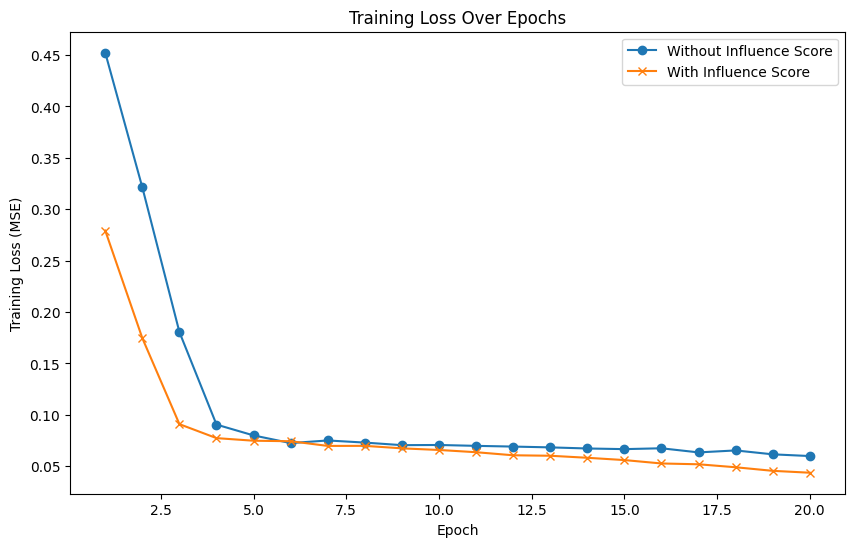

Mean Absolute Error without Influence Score: 0.2104292202454347
Root Mean Square Error without Influence Score: 0.24481152800413278
Mean Absolute Error with Influence Score: 0.17275971346176588
Root Mean Square Error with Influence Score: 0.20155597650087798


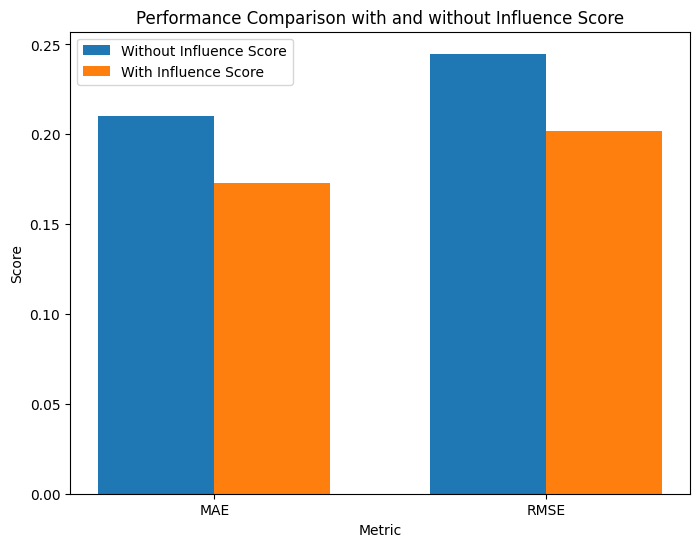

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt

# Define dataset class for trajectory data
class TrajectoryDataset(Dataset):
    def __init__(self, data, use_influence_score=False):
        self.data = data
        self.use_influence_score = use_influence_score

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        trajectory = sample['trajectory']
        if self.use_influence_score:
            influence_score = sample['influence_score']
            return torch.tensor(trajectory, dtype=torch.float32), torch.tensor([influence_score], dtype=torch.float32)
        return torch.tensor(trajectory, dtype=torch.float32), torch.tensor([0], dtype=torch.float32)

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, use_influence_score=False):
        super(TrajectoryLSTM, self).__init__()
        self.use_influence_score = use_influence_score
        input_features = input_dim + 1 if use_influence_score else input_dim
        self.lstm = nn.LSTM(input_features, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, influence_score=None):
        if self.use_influence_score and influence_score is not None:
            # Ensure influence_score has the correct shape for concatenation
            influence_score = influence_score.unsqueeze(1).repeat(1, x.size(1), 1)  # Repeat along the sequence dimension
            x = torch.cat((x, influence_score), dim=2)  # Add influence score as an additional feature
            
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])  # Predict only the final timestep

# Training function
def train(model, loader, optimizer, criterion, use_influence_score):
    model.train()
    total_loss = 0
    for trajectory, influence_score in loader:
        optimizer.zero_grad()
        if use_influence_score:
            output = model(trajectory, influence_score)
        else:
            output = model(trajectory)
        loss = criterion(output, trajectory[:, -1, :])  # Predicting the last position
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Initialize models, loss function, and optimizer
input_dim = 2  # (x, y) position
hidden_dim = 32
output_dim = 2  # Predict next (x, y) position
num_epochs = 20

# Model without influence score
model_without = TrajectoryLSTM(input_dim, hidden_dim, output_dim, use_influence_score=False)
optimizer_without = optim.Adam(model_without.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Model with influence score
model_with = TrajectoryLSTM(input_dim, hidden_dim, output_dim, use_influence_score=True)
optimizer_with = optim.Adam(model_with.parameters(), lr=0.001)

# Generate synthetic data samples
def generate_data_samples(num_samples=100):
    data_samples = []
    for _ in range(num_samples):
        trajectory = np.random.rand(10, 2)  # Example 10-step trajectory with (x, y) positions
        influence_score = np.random.rand()  # Random influence score
        data_samples.append({'trajectory': trajectory, 'influence_score': influence_score})
    return data_samples

# Load and prepare data
data_samples = generate_data_samples()
train_data_without = TrajectoryDataset(data_samples, use_influence_score=False)
train_data_with = TrajectoryDataset(data_samples, use_influence_score=True)

train_loader_without = DataLoader(train_data_without, batch_size=8, shuffle=True)
train_loader_with = DataLoader(train_data_with, batch_size=8, shuffle=True)

# Training loop and tracking losses for plotting
losses_without = []
losses_with = []
for epoch in range(num_epochs):
    loss_without = train(model_without, train_loader_without, optimizer_without, criterion, use_influence_score=False)
    loss_with = train(model_with, train_loader_with, optimizer_with, criterion, use_influence_score=True)
    losses_without.append(loss_without)
    losses_with.append(loss_with)
    print(f'Epoch {epoch+1}, Loss without influence score: {loss_without}, Loss with influence score: {loss_with}')

# Plot training losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), losses_without, label='Without Influence Score', marker='o')
plt.plot(range(1, num_epochs + 1), losses_with, label='With Influence Score', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

# Evaluate models using MAE and RMSE
def evaluate(model, loader, use_influence_score):
    model.eval()
    mae_total, rmse_total, count = 0, 0, 0
    with torch.no_grad():
        for trajectory, influence_score in loader:
            if use_influence_score:
                output = model(trajectory, influence_score)
            else:
                output = model(trajectory)
            # Calculate MAE and RMSE
            mae = torch.mean(torch.abs(output - trajectory[:, -1, :]))
            rmse = torch.sqrt(torch.mean((output - trajectory[:, -1, :])**2))
            mae_total += mae.item()
            rmse_total += rmse.item()
            count += 1
    return mae_total / count, rmse_total / count

mae_without, rmse_without = evaluate(model_without, train_loader_without, use_influence_score=False)
mae_with, rmse_with = evaluate(model_with, train_loader_with, use_influence_score=True)

print(f'Mean Absolute Error without Influence Score: {mae_without}')
print(f'Root Mean Square Error without Influence Score: {rmse_without}')
print(f'Mean Absolute Error with Influence Score: {mae_with}')
print(f'Root Mean Square Error with Influence Score: {rmse_with}')

# Plot MAE and RMSE comparison
labels = ['MAE', 'RMSE']
metrics_without = [mae_without, rmse_without]
metrics_with = [mae_with, rmse_with]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width / 2, metrics_without, width, label='Without Influence Score')
rects2 = ax.bar(x + width / 2, metrics_with, width, label='With Influence Score')

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison with and without Influence Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()